In [2]:
from unimatch.unimatch.unimatch import UniMatch
import torch


model_path = "unimatch/gmstereo-scale1-resumeflowthings-sceneflow-16e38788.pth"
model = UniMatch(num_scales=1, task='stereo')
checkpoint_flow = torch.load(model_path)

if 'model' in checkpoint_flow:
    model.load_state_dict(checkpoint_flow['model'], strict=True)
else:
    model.load_state_dict(checkpoint_flow, strict=True)







Device: cuda


d:\mukul\anaconda3\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
d:\mukul\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Total images to process:  112


d:\mukul\anaconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


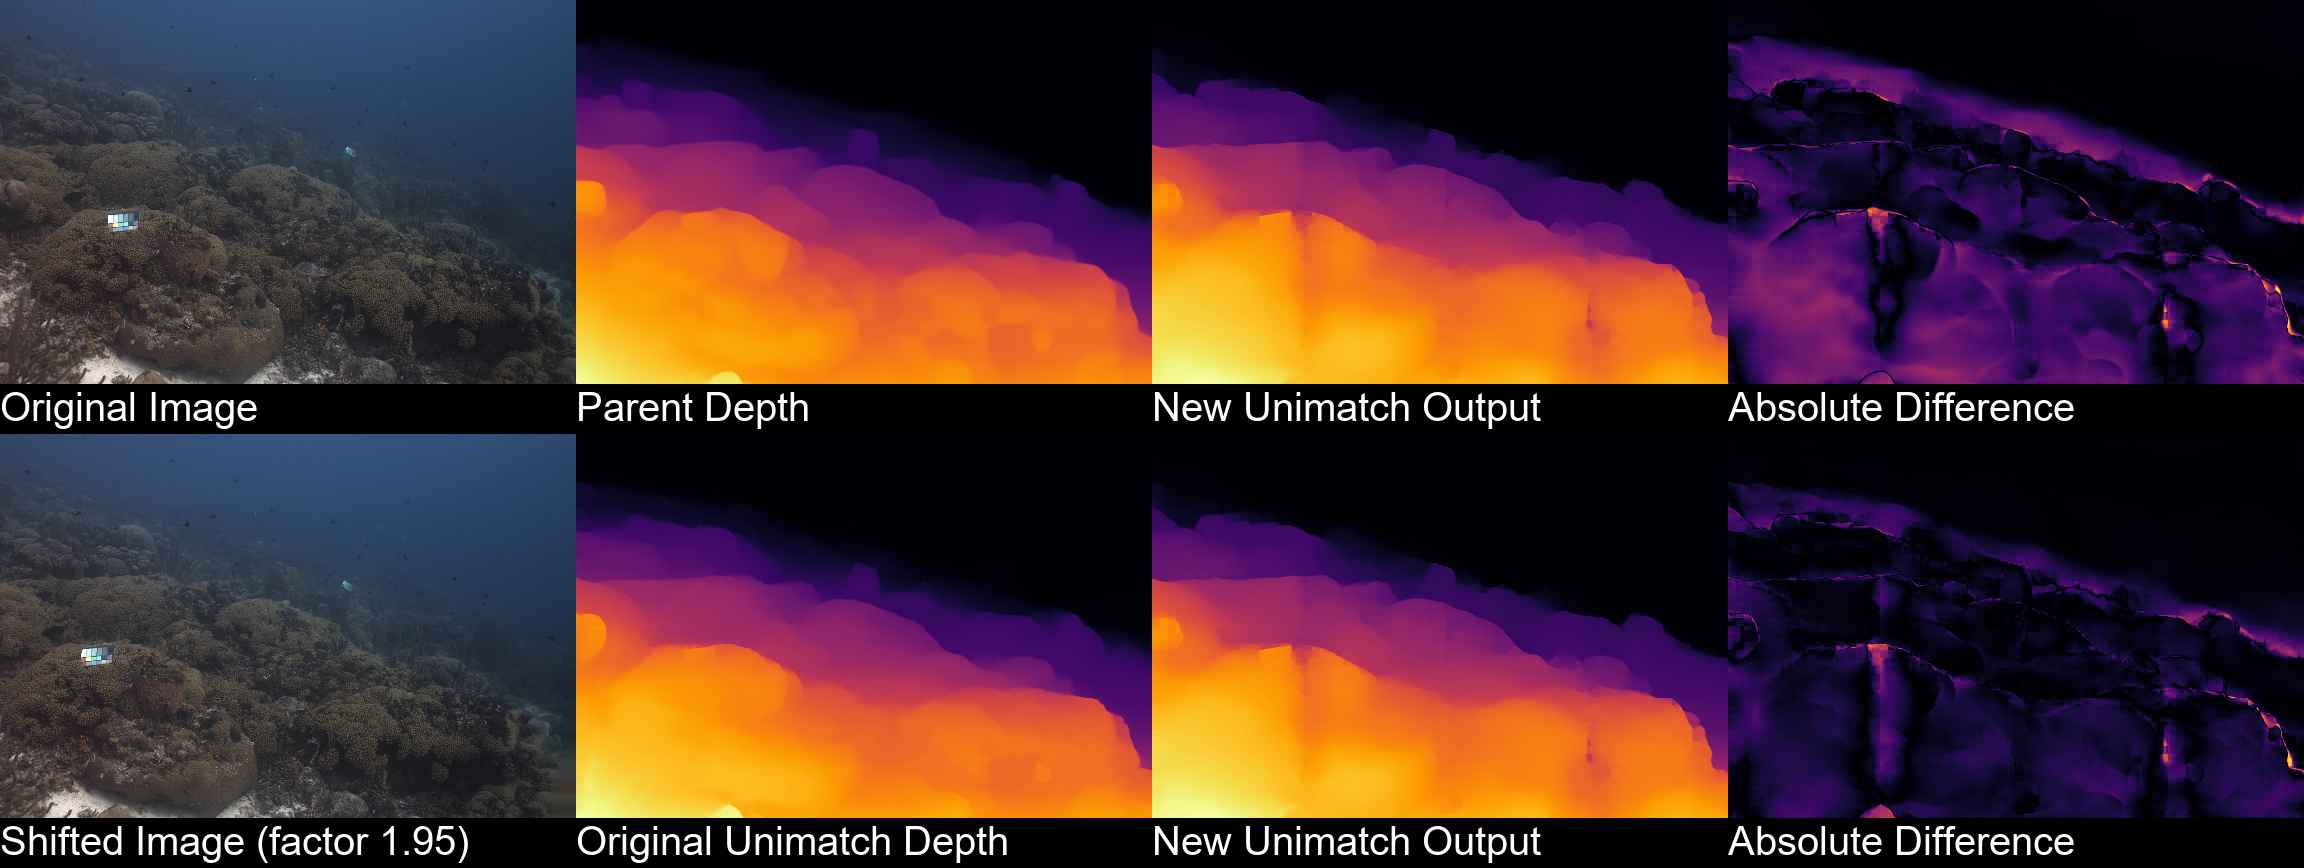

In [1]:
import Pude_training_loop.loss_functions_torch as loss_functions
import Pude_training_loop.pude_utils as pude_utils
import Pude_training_loop.model_training as model_training
import Pude_training_loop.dataset_loader as data_loader
from monocular_stereo_matching.stereo_pair_gen import Stereo_Pair_Generator
import torch
from PIL import Image
import pickle
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
depth_anything_model, depth_anything_image_processor = model_training.get_model_image_processor_pair(model_name="depth_anything", model_path=model_training.models["depth_anything"], device=device)
unimatch_model, unimatch_image_processor = model_training.get_model_image_processor_pair(model_name="unimatch_small", model_path=model_training.models["unimatch_small"], device=device)
org_unimatch_model, org_unimatch_image_processor = model_training.get_model_image_processor_pair(model_name="unimatch", model_path=model_training.models["unimatch"], device=device)
dataset_loader = data_loader.DatasetLoader() # Initialize dataset loader with default parameters

stereo_pair_gen = Stereo_Pair_Generator(image_dim=model_training.default_image_dim)



# seed the torch
torch.manual_seed(model_training.seed)
np.random.seed(model_training.seed)


#  load the underwater params from pickle file
underwater_param_file = "Results/SeaThru_Combined/Datalogger_params/params/parameter_results.pickle"
underwater_params = pude_utils.load_pickle(underwater_param_file)
skipped_images = [5,  14, 23, 24, 25, 28, 37, 38, 39, 41, 
                42, 43, 45, 46, 51, 52, 53, 55, 56, 57, 59, 
                61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73,  74, 75, 76, 77, 78, 81, 82, 
                83, 85,  86, 87, 88, 89, 90, 93,94,  95, 96, 97, 107, 108, 112, 113, 118, 119, 122, 123, 124, 127, 130, 131, 171, 172, 173, 174,
                175, 177, 179 ]


print("Total images to process: ", len(dataset_loader)-len(skipped_images))

# create a random list of indices to shuffle the images in the dataset
indices = np.random.permutation(len(dataset_loader))

non_linear_images, linear_images = dataset_loader[0]
non_linear_images_tensor = torch.tensor(non_linear_images)


# scaling_factor = np.random.randint(0.8, 5) # [2, 5)
depth_anything_output = model_training.get_model_output(model=depth_anything_model, 
                                                                image_processor=depth_anything_image_processor, 
                                                                raw_image=non_linear_images_tensor, device=device, requires_grad=False)

# generate stereo pair #depth anything 1.5 scaling #pude 0.005 scaling
scaling_factor = np.random.uniform(0.4, 5)      
image_2 = stereo_pair_gen.generate_stereo_pair(non_linear_images, depth_anything_output.cpu().detach().numpy(), scaling_factor=scaling_factor)

unimatch_input = {"image1": non_linear_images, "image2": image_2}
unimatch_output = model_training.get_model_output(model=unimatch_model, 
                                            image_processor=unimatch_image_processor, 
                                            raw_image=unimatch_input, device=device)
org_unimatch_output = model_training.get_model_output(model=org_unimatch_model,
                                                        image_processor=org_unimatch_image_processor,
                                                        raw_image=unimatch_input, device=device, requires_grad=False)
        
        

result_images = pude_utils.unimatch_display_image_with_depth2(image=Image.fromarray(non_linear_images),
                                                            depth1=depth_anything_output.cpu().detach().numpy(),
                                                            depth2=unimatch_output.cpu().detach().numpy(),
                                                            shifted_image=Image.fromarray(image_2), 
                                                            scaling_factor=scaling_factor,
                                                            org_depth=org_unimatch_output.cpu().detach().numpy())

display(result_images)

# torch.save(unimatch_model.state_dict(), f"new_unimatch_model_with_new_pude_edge_aware_loss_cosine_scheduler_AdamW_betas_{betas_str}_lr_{str(learning_rate)}_epochs_3.pth")

# Save the model
# torch.save(new_pude_model.state_dict(), "new_pude_model_2.pth")
